# 🌎 Welcome to the CSE151B Spring 2025 Climate Emulation Competition!

Thank you for participating in this exciting challenge focused on building machine learning models to emulate complex climate systems.  
This notebook is provided as a **starter template** to help you:

- Understand how to load and preprocess the dataset  
- Construct a baseline model  
- Train and evaluate predictions using a PyTorch Lightning pipeline  
- Format your predictions for submission to the leaderboard  

You're encouraged to:
- Build on this structure or replace it entirely
- Try more advanced models and training strategies
- Incorporate your own ideas to push the boundaries of what's possible

If you're interested in developing within a repository structure and/or use helpful tools like configuration management (based on Hydra) and logging (with Weights & Biases), we recommend checking out the following Github repo. Such a structure can be useful when running multiple experiments and trying various research ideas.

👉 [https://github.com/salvaRC/cse151b-spring2025-competition](https://github.com/salvaRC/cse151b-spring2025-competition)

Good luck, have fun, and we hope you learn a lot through this process!


### 📦 Install Required Libraries
We install the necessary Python packages for data loading, deep learning, and visualization.


In [3]:
!pip install xarray zarr dask lightning matplotlib wandb cftime einops --quiet

ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: '/opt/conda/lib/python3.11/site-packages/__pycache__/typing_extensions.cpython-311.pyc'
Consider using the `--user` option or check the permissions.



In [1]:
import os
from datetime import datetime
import numpy as np
import xarray as xr
import dask.array as da
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl

### ⚙️ Configuration Setup  
Define all model, data, and training hyperparameters in one place for easy control and reproducibility.

### 📊 Data Configuration

We define the dataset settings used for training and evaluation. This includes:

- **`path`**: Path to the `.zarr` dataset containing monthly climate variables from CMIP6 simulations.
- **`input_vars`**: Climate forcing variables (e.g., CO₂, CH₄) used as model inputs.
- **`output_vars`**: Target variables to predict — surface air temperature (`tas`) and precipitation (`pr`).
- **`target_member_id`**: Ensemble member to use from the simulations (each SSP has 3) for target variables.
- **`train_ssps`**: SSP scenarios used for training (low to high emissions).
- **`test_ssp`**: Scenario held out for evaluation (Must be set to SSP245).
- **`test_months`**: Number of months to include in the test split (Must be set to 120).
- **`batch_size`** and **`num_workers`**: Data loading parameters for PyTorch training.

These settings reflect how the challenge is structured: models must learn from some emission scenarios and generalize to unseen ones.

> ⚠️ **Important:** Do **not modify** the following test settings:
>
> - `test_ssp` must remain **`ssp245`**, which is the held-out evaluation scenario.
> - `test_months` must be **`120`**, corresponding to the last 10 years (monthly resolution) of the scenario.



In [23]:
#NOTE Change the data directory according to where you have your zarr files stored
config = {
    "data": {
        "path": "../data/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas", "pr"],
        "target_member_id": 0,
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245",
        "test_months": 360,
        "batch_size": 64,
        "num_workers": 4,
    },
    "model": {
        "type": "simple_cnn",
        "kernel_size": 3,
        "init_dim": 64,
        "depth": 4,
        "dropout_rate": 0.1,
    },
    "training": {
        "lr": 1e-3,
    },
    "trainer": {
        "max_epochs": 10,
        "accelerator": "auto",
        "devices": "auto",
        "precision": 32,
        "deterministic": True,
        "num_sanity_val_steps": 0,
    },
    "seed": 42,
}
pl.seed_everything(config["seed"])  # Set seed for reproducibility

Seed set to 42


42

### 🔧 Spatial Weighting Utility Function

This cell sets up utility functions for reproducibility and spatial weighting:

- **`get_lat_weights(latitude_values)`**: Computes cosine-based area weights for each latitude, accounting for the Earth's curvature. This is critical for evaluating global climate metrics fairly — grid cells near the equator represent larger surface areas than those near the poles.


In [24]:
def get_lat_weights(latitude_values):
    lat_rad = np.deg2rad(latitude_values)
    weights = np.cos(lat_rad)
    return weights / np.mean(weights)

### 🧠 SimpleCNN: A Residual Convolutional Baseline

This is a lightweight baseline model designed to capture spatial patterns in global climate data using convolutional layers.

- The architecture starts with a **convolution + batch norm + ReLU** block to process the input channels.
- It then applies a series of **residual blocks** to extract increasingly abstract spatial features. These help preserve gradient flow during training.
- Finally, a few convolutional layers reduce the feature maps down to the desired number of output channels (`tas` and `pr`).

This model only serves as a **simple baseline for climate emulation**. 

We encourage you to build and experiment with your own models and ideas.


In [25]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride), nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip(identity)
        return self.relu(out)

class SimpleCNN(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, kernel_size=3, init_dim=64, depth=4, dropout_rate=0.2):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(n_input_channels, init_dim, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(init_dim),
            nn.ReLU(inplace=True),
        )
        self.res_blocks = nn.ModuleList()
        current_dim = init_dim
        for i in range(depth):
            out_dim = current_dim * 2 if i < depth - 1 else current_dim
            self.res_blocks.append(ResidualBlock(current_dim, out_dim))
            if i < depth - 1:
                current_dim *= 2
        self.dropout = nn.Dropout2d(dropout_rate)
        self.final = nn.Sequential(
            nn.Conv2d(current_dim, current_dim // 2, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(current_dim // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(current_dim // 2, n_output_channels, kernel_size=1),
        )

    def forward(self, x):
        x = self.initial(x)
        for res_block in self.res_blocks:
            x = res_block(x)
        return self.final(self.dropout(x))


### 📐 Normalizer: Z-Score Scaling for Climate Inputs & Outputs

This class handles **Z-score normalization**, a crucial preprocessing step for stable and efficient neural network training:

- **`set_input_statistics(mean, std)` / `set_output_statistics(...)`**: Store the mean and standard deviation computed from the training data for later use.
- **`normalize(data, data_type)`**: Standardizes the data using `(x - mean) / std`. This is applied separately to inputs and outputs.
- **`inverse_transform_output(data)`**: Converts model predictions back to the original physical units (e.g., Kelvin for temperature, mm/day for precipitation).

Normalizing the data ensures the model sees inputs with similar dynamic ranges and avoids biases caused by different variable scales.


In [26]:
class Normalizer:
    def __init__(self):
        self.mean_in, self.std_in = None, None
        self.mean_out, self.std_out = None, None

    def set_input_statistics(self, mean, std):
        self.mean_in = mean
        self.std_in = std

    def set_output_statistics(self, mean, std):
        self.mean_out = mean
        self.std_out = std

    def normalize(self, data, data_type):
        if data_type == "input":
            return (data - self.mean_in) / self.std_in
        elif data_type == "output":
            return (data - self.mean_out) / self.std_out

    def inverse_transform_output(self, data):
        return data * self.std_out + self.mean_out


### 🌍 Data Module: Loading, Normalization, and Splitting

This section handles the entire data pipeline, from loading the `.zarr` dataset to preparing PyTorch-ready DataLoaders.

#### `ClimateDataset`
- A simple PyTorch `Dataset` wrapper that preloads the entire (normalized) dataset into memory using Dask.
- Converts the data to PyTorch tensors and handles any `NaN` checks up front.

#### `ClimateDataModule`
A PyTorch Lightning `DataModule` that handles:
- ✅ **Loading data** from different SSP scenarios and ensemble members
- ✅ **Broadcasting non-spatial inputs** (like CO₂) to match spatial grid size
- ✅ **Normalization** using mean/std computed from training data only
- ✅ **Splitting** into training, validation, and test sets:
  - Training: All months from selected SSPs (except last 10 years of SSP370)
  - Validation: Last 10 years (120 months) of SSP370
  - Test: Last 10 years of SSP245 (unseen scenario)
- ✅ **Batching** and parallelized data loading via PyTorch `DataLoader`s
- ✅ **Latitude-based area weighting** for fair climate metric evaluation
- Shape of the inputs are Batch_Size X 5 (num_input_variables) X 48 X 72
- Shape of ouputputs are Batch_Size X 2 (num_output_variables) X 48 X 72

> ℹ️ **Note:** You likely won’t need to modify this class but feel free to make modifications if you want to inlcude different ensemble mebers to feed more data to your models


In [27]:
class ClimateDataset(Dataset):
    def __init__(self, inputs_dask, outputs_dask, output_is_normalized=True):
        self.size = inputs_dask.shape[0]
        print(f"Creating dataset with {self.size} samples...")

        inputs_np = inputs_dask.compute()
        outputs_np = outputs_dask.compute()

        self.inputs = torch.from_numpy(inputs_np).float()
        self.outputs = torch.from_numpy(outputs_np).float()

        if torch.isnan(self.inputs).any() or torch.isnan(self.outputs).any():
            raise ValueError("NaNs found in dataset")

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


class ClimateDataModule(pl.LightningDataModule):
    def __init__(
        self,
        path,
        input_vars,
        output_vars,
        train_ssps,
        test_ssp,
        target_member_id,
        val_split=0.1,
        test_months=360,
        batch_size=32,
        num_workers=0,
        seed=42,
    ):
        super().__init__()
        self.path = path
        self.input_vars = input_vars
        self.output_vars = output_vars
        self.train_ssps = train_ssps
        self.test_ssp = test_ssp
        self.target_member_id = target_member_id
        self.val_split = val_split
        self.test_months = test_months
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed
        self.normalizer = Normalizer()

    def prepare_data(self):
        assert os.path.exists(self.path), f"Data path not found: {self.path}"

    def setup(self, stage=None):
        ds = xr.open_zarr(self.path, consolidated=False, chunks={"time": 24})
        spatial_template = ds["rsdt"].isel(time=0, ssp=0, drop=True)

        def load_ssp(ssp):
            input_dask, output_dask = [], []
            for var in self.input_vars:
                da_var = ds[var].sel(ssp=ssp)
                if "latitude" in da_var.dims:
                    da_var = da_var.rename({"latitude": "y", "longitude": "x"})
                if "member_id" in da_var.dims:
                    da_var = da_var.sel(member_id=self.target_member_id)
                if set(da_var.dims) == {"time"}:
                    da_var = da_var.broadcast_like(spatial_template).transpose("time", "y", "x")
                input_dask.append(da_var.data)

            for var in self.output_vars:
                da_out = ds[var].sel(ssp=ssp, member_id=self.target_member_id)
                if "latitude" in da_out.dims:
                    da_out = da_out.rename({"latitude": "y", "longitude": "x"})
                output_dask.append(da_out.data)

            return da.stack(input_dask, axis=1), da.stack(output_dask, axis=1)

        train_input, train_output, val_input, val_output = [], [], None, None

        for ssp in self.train_ssps:
            x, y = load_ssp(ssp)
            if ssp == "ssp370":
                val_input = x[-self.test_months:]
                val_output = y[-self.test_months:]
                train_input.append(x[:-self.test_months])
                train_output.append(y[:-self.test_months])
            else:
                train_input.append(x)
                train_output.append(y)

        train_input = da.concatenate(train_input, axis=0)
        train_output = da.concatenate(train_output, axis=0)

        self.normalizer.set_input_statistics(
            mean=da.nanmean(train_input, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_input, axis=(0, 2, 3), keepdims=True).compute(),
        )
        self.normalizer.set_output_statistics(
            mean=da.nanmean(train_output, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_output, axis=(0, 2, 3), keepdims=True).compute(),
        )

        train_input_norm = self.normalizer.normalize(train_input, "input")
        train_output_norm = self.normalizer.normalize(train_output, "output")
        val_input_norm = self.normalizer.normalize(val_input, "input")
        val_output_norm = self.normalizer.normalize(val_output, "output")

        test_input, test_output = load_ssp(self.test_ssp)
        test_input = test_input[-self.test_months:]
        test_output = test_output[-self.test_months:]
        test_input_norm = self.normalizer.normalize(test_input, "input")

        self.train_dataset = ClimateDataset(train_input_norm, train_output_norm)
        self.val_dataset = ClimateDataset(val_input_norm, val_output_norm)
        self.test_dataset = ClimateDataset(test_input_norm, test_output, output_is_normalized=False)

        self.lat = spatial_template.y.values
        self.lon = spatial_template.x.values
        self.area_weights = xr.DataArray(get_lat_weights(self.lat), dims=["y"], coords={"y": self.lat})

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def get_lat_weights(self):
        return self.area_weights

    def get_coords(self):
        return self.lat, self.lon

### ⚡ ClimateEmulationModule: Lightning Wrapper for Climate Model Emulation

This is the core model wrapper built with **PyTorch Lightning**, which organizes the training, validation, and testing logic for the climate emulation task. Lightning abstracts away much of the boilerplate code in PyTorch-based deep learning workflows, making it easier to scale models.

#### ✅ Key Features

- **`training_step` / `validation_step` / `test_step`**: Standard Lightning hooks for computing loss and predictions at each stage. The loss used is **Mean Squared Error (MSE)**.

- **Normalization-aware outputs**:
  - During validation and testing, predictions and targets are denormalized before evaluation using stored mean/std statistics.
  - This ensures evaluation is done in real-world units (Kelvin and mm/day).

- **Metric Evaluation** via `_evaluate()`:
  For each variable (`tas`, `pr`), it calculates:
  - **Monthly Area-Weighted RMSE**
  - **Time-Mean RMSE** (RMSE on 10-year average's)
  - **Time-Stddev MAE** (MAE on 10-year standard deviation; a measure of temporal variability)
    
  These metrics reflect the competition's evaluation criteria and are logged and printed.

- **Kaggle Submission Writer**:
  After testing, predictions are saved to a `.csv` file in the required Kaggle format via `_save_submission()`.

- **Saving Predictions for Visualization**:
  - Validation predictions are saved tao `val_preds.npy` and `val_trues.npy`
  - These can be loaded later for visual inspection of the model's performance.

 🔧 **Feel free to modify any part of this module** (loss functions, evaluation, training logic) to better suit your model or training pipeline / Use pure PyTorch etc.

⚠️ The **final submission `.csv` file must strictly follow the format and naming convention used in `_save_submission()`**, as these `ID`s are used to match predictions to the hidden test set during evaluation.



In [28]:
import pandas as pd

class ClimateEmulationModule(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4):
        super().__init__()
        self.model = model
        self.save_hyperparameters(ignore=['model']) # Save all hyperparameters except the model to self.hparams.<param_name>
        self.criterion = nn.MSELoss()
        self.normalizer = None
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []

    def forward(self, x):
        return self.model(x)

    def on_fit_start(self):
        self.normalizer = self.trainer.datamodule.normalizer  # Get the normalizer from the datamodule (see above)

    def on_test_start(self):
        self.normalizer = self.trainer.datamodule.normalizer

    def training_step(self, batch, batch_idx):
        x, y = batch # Unpack inputs and targets (this is the output of the _getitem_ method in the Dataset above)
        y_hat = self(x)   # Forward pass
        loss = self.criterion(y_hat, y)  # Calculate loss
        self.log("train/loss", loss)  # Log loss for tracking
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val/loss", loss)

        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = self.normalizer.inverse_transform_output(y.detach().cpu().numpy())
        self.val_preds.append(y_hat_np)
        self.val_targets.append(y_np)

        return loss

    def on_validation_epoch_end(self):
        # Concatenate all predictions and ground truths from each val step/batch into one array
        preds = np.concatenate(self.val_preds, axis=0)
        trues = np.concatenate(self.val_targets, axis=0)
        self._evaluate(preds, trues, phase="val")
        np.save("val_preds.npy", preds)
        np.save("val_trues.npy", trues)
        self.val_preds.clear()
        self.val_targets.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = y.detach().cpu().numpy()
        self.test_preds.append(y_hat_np)
        self.test_targets.append(y_np)

    def on_test_epoch_end(self):
        # Concatenate all predictions and ground truths from each test step/batch into one array
        preds = np.concatenate(self.test_preds, axis=0)
        trues = np.concatenate(self.test_targets, axis=0)
        self._evaluate(preds, trues, phase="test")
        self._save_submission(preds)
        self.test_preds.clear()
        self.test_targets.clear()

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

    def _evaluate(self, preds, trues, phase="val"):
        datamodule = self.trainer.datamodule
        area_weights = datamodule.get_lat_weights()
        lat, lon = datamodule.get_coords()
        time = np.arange(preds.shape[0])
        output_vars = datamodule.output_vars

        for i, var in enumerate(output_vars):
            p = preds[:, i]
            t = trues[:, i]
            p_xr = xr.DataArray(p, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
            t_xr = xr.DataArray(t, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

            # RMSE
            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean(("time", "y", "x")).item())
            # RMSE of time-mean
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2).weighted(area_weights).mean(("y", "x")).item())
            # MAE of time-stddev
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean(("y", "x")).item()

            print(f"[{phase.upper()}] {var}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            self.log_dict({
                f"{phase}/{var}/rmse": rmse,
                f"{phase}/{var}/time_mean_rmse": mean_rmse,
                f"{phase}/{var}/time_std_mae": std_mae,
            })

    def _save_submission(self, predictions):
        datamodule = self.trainer.datamodule
        lat, lon = datamodule.get_coords()
        output_vars = datamodule.output_vars
        time = np.arange(predictions.shape[0])

        rows = []
        for t_idx, t in enumerate(time):
            for var_idx, var in enumerate(output_vars):
                for y_idx, y in enumerate(lat):
                    for x_idx, x in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var}_{y:.2f}_{x:.2f}"
                        pred = predictions[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred})

        df = pd.DataFrame(rows)
        os.makedirs("submissions", exist_ok=True)
        filepath = f"submissions/kaggle_submission_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filepath, index=False)
        print(f"✅ Submission saved to: {filepath}")

### ⚡ Training & Evaluation with PyTorch Lightning

This block sets up and runs the training and testing pipeline using **PyTorch Lightning’s `Trainer`**, which abstracts away much of the boilerplate in deep learning workflows.

- **Modular Setup**:
  - `datamodule`: Handles loading, normalization, and batching of climate data.
  - `model`: A convolutional neural network that maps climate forcings to predicted outputs.
  - `lightning_module`: Wraps the model with training/validation/test logic and metric evaluation.

- **Trainer Flexibility**:
  The `Trainer` accepts a wide range of configuration options from `config["trainer"]`, including:
  - Number of epochs
  - Precision (e.g., 16-bit or 32-bit)
  - Device configuration (CPU, GPU, or TPU)
  - Determinism, logging, callbacks, and more

### Linear Regressor Baseline Training

In [29]:
class LinearRegressor(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, height, width):
        super().__init__()
        self.height = height
        self.width = width
        self.linear = nn.Linear(n_input_channels * height * width, n_output_channels * height * width)

    def forward(self, x):
        B, C, H, W = x.size()
        x = x.view(B, -1)  # Flatten (B, C*H*W)
        x = self.linear(x)  # Apply linear transformation
        x = x.view(B, -1, H, W)  # Reshape to (B, out_channels, H, W)
        return x


In [30]:
datamodule = ClimateDataModule(**config["data"])

In [31]:
model = LinearRegressor(
    n_input_channels=len(config["data"]["input_vars"]),
    n_output_channels=len(config["data"]["output_vars"]),
    height=48,  # Add these keys to config
    width=72
)

In [32]:
lightning_module = ClimateEmulationModule(model, learning_rate=config["training"]["lr"])

trainer = pl.Trainer(**config["trainer"])
trainer.fit(lightning_module, datamodule=datamodule)   # Training

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | LinearRegressor | 119 M  | train
1 | criterion | MSELoss         | 0      | train
------------------------------------------------------
119 M     Trainable params
0         Non-trainable params
119 M     Total params
477.785   Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/home/enew/.local/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 60.57it/s, v_num=46]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 6/6 [00:00<00:00,  9.06it/s][VAL] tas: RMSE=16.2369, Time-Mean RMSE=14.8625, Time-Stddev MAE=3.4834
[VAL] pr: RMSE=3.6874, Time-Mean RMSE=2.5209, Time-Stddev MAE=1.1068

Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 49.45it/s, v_num=46]    
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 11.07it/s][VAL] tas: RMSE=4.7512, Time-Mean RMSE=3.5441, Time-Stddev MAE=0.7884
[VAL] pr: RMSE=3.0216, Time-Mean RMSE=1.6273, Time-Stddev MAE=1.2252

Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 49.95it/s, v_num=46]    
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 12.64it/s][VAL] tas: RMSE=3.9678, Time-Mean RMSE=2.6481, Time-Stddev MAE=1.2605
[VAL] pr: RMSE=3.0178, Time-Mean RMSE=1.6286, Time-Stddev MAE=1.2638

Epoch 3: 100%|███████

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 43/43 [00:06<00:00,  6.84it/s, v_num=46]


In [33]:
trainer.save_checkpoint("./models/linear.ckpt")

### MLP Training

In [62]:
class MLPRegressor(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, height, width, hidden_dim=1024, dropout_rate=0.2):
        super().__init__()
        self.height = height
        self.width = width
        input_dim = n_input_channels * height * width
        output_dim = n_output_channels * height * width

        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        B, C, H, W = x.size()
        x = x.view(B, -1)
        x = self.model(x)
        x = x.view(B, -1, H, W)
        return x

In [63]:
datamodule = ClimateDataModule(**config["data"])

In [64]:
model = MLPRegressor(n_input_channels=5, n_output_channels=2, height=48, width=72)

In [65]:
lightning_module = ClimateEmulationModule(model, learning_rate=config["training"]["lr"])
trainer = pl.Trainer(**config["trainer"])
trainer.fit(lightning_module, datamodule=datamodule)   # Training

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type         | Params | Mode 
---------------------------------------------------
0 | model     | MLPRegressor | 25.8 M | train
1 | criterion | MSELoss      | 0      | train
---------------------------------------------------
25.8 M    Trainable params
0         Non-trainable params
25.8 M    Total params
103.321   Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/home/enew/.local/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 73.35it/s, v_num=53]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 12.13it/s][VAL] tas: RMSE=7.0735, Time-Mean RMSE=4.6253, Time-Stddev MAE=2.4752
[VAL] pr: RMSE=2.7090, Time-Mean RMSE=0.6821, Time-Stddev MAE=1.2573

Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 53.62it/s, v_num=53]    
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 16.68it/s][VAL] tas: RMSE=4.4513, Time-Mean RMSE=2.3548, Time-Stddev MAE=1.2369
[VAL] pr: RMSE=2.5790, Time-Mean RMSE=0.4646, Time-Stddev MAE=1.2658

Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 52.76it/s, v_num=53]    
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 11.45it/s][VAL] tas: RMSE=5.4019, Time-Mean RMSE=4.0929, Time-Stddev MAE=1.3065
[VAL] pr: RMSE=2.5951, Time-Mean RMSE=0.5450, Time-Stddev MAE=1.4583

Epoch 3: 100%|█████████

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 43/43 [00:02<00:00, 15.12it/s, v_num=53]


In [38]:
trainer.save_checkpoint("./models/MLP.ckpt")

### SimpleCNN Training

In [39]:
datamodule = ClimateDataModule(**config["data"])

In [40]:
model = SimpleCNN(
    n_input_channels=len(config["data"]["input_vars"]),
    n_output_channels=len(config["data"]["output_vars"]),
    **{k: v for k, v in config["model"].items() if k != "type"}
)

In [41]:
lightning_module = ClimateEmulationModule(model, learning_rate=config["training"]["lr"])
trainer = pl.Trainer(**config["trainer"])
trainer.fit(lightning_module, datamodule=datamodule)   # Training

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | model     | SimpleCNN | 10.7 M | train
1 | criterion | MSELoss   | 0      | train
------------------------------------------------
10.7 M    Trainable params
0         Non-trainable params
10.7 M    Total params
42.923    Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode
/home/enew/.local/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 43/43 [00:24<00:00,  1.78it/s, v_num=48]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 6/6 [00:02<00:00,  2.92it/s][VAL] tas: RMSE=10.0650, Time-Mean RMSE=8.4995, Time-Stddev MAE=2.3893
[VAL] pr: RMSE=3.4688, Time-Mean RMSE=2.0937, Time-Stddev MAE=1.9937

Epoch 1: 100%|██████████| 43/43 [00:25<00:00,  1.69it/s, v_num=48]    
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 6/6 [00:02<00:00,  2.80it/s][VAL] tas: RMSE=8.1090, Time-Mean RMSE=5.6228, Time-Stddev MAE=3.0034
[VAL] pr: RMSE=3.3625, Time-Mean RMSE=1.8743, Time-Stddev MAE=1.7242

Epoch 2: 100%|██████████| 43/43 [00:25<00:00,  1.67it/s, v_num=48]    
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 6/6 [00:02<00:00,  2.81it/s][VAL] tas: RMSE=8.1191, Time-Mean RMSE=6.5957, Time-Stddev MAE=1.9883
[VAL] pr: RMSE=3.2515, Time-Mean RMSE=1.7396, Time-Stddev MAE=1.6267

Epoch 3: 100%|████████

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 43/43 [00:28<00:00,  1.49it/s, v_num=48]


In [42]:
trainer.save_checkpoint("./models/simpleCNN.ckpt")

### SimpleConstantCNN Training

In [43]:
class SimpleConstantCNN(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, kernel_size=3, init_dim=64, depth=4, dropout_rate=0.2):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(n_input_channels, init_dim, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(init_dim),
            nn.ReLU(inplace=True),
        )
        self.res_blocks = nn.ModuleList()
        current_dim = init_dim
        for i in range(depth):
            out_dim = current_dim
            self.res_blocks.append(ResidualBlock(current_dim, out_dim))
            # if i < depth - 1:
            #     current_dim *= 2
        self.dropout = nn.Dropout2d(dropout_rate)
        self.final = nn.Sequential(
            nn.Conv2d(current_dim, current_dim // 2, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(current_dim // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(current_dim // 2, n_output_channels, kernel_size=1),
        )

    def forward(self, x):
        x = self.initial(x)
        for res_block in self.res_blocks:
            x = res_block(x)
        return self.final(self.dropout(x))

In [44]:
datamodule = ClimateDataModule(**config["data"])

In [45]:
model = SimpleConstantCNN(
    n_input_channels=len(config["data"]["input_vars"]),
    n_output_channels=len(config["data"]["output_vars"]),
    **{k: v for k, v in config["model"].items() if k != "type"}
)

In [46]:
lightning_module = ClimateEmulationModule(model, learning_rate=config["training"]["lr"])
trainer = pl.Trainer(**config["trainer"])
trainer.fit(lightning_module, datamodule=datamodule)   # Training

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | SimpleConstantCNN | 318 K  | train
1 | criterion | MSELoss           | 0      | train
--------------------------------------------------------
318 K     Trainable params
0         Non-trainable params
318 K     Total params
1.272     Total estimated model params size (MB)
41        Modules in train mode
0         Modules in eval mode
/home/enew/.local/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 43/43 [00:02<00:00, 17.81it/s, v_num=49]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 11.02it/s][VAL] tas: RMSE=7.9629, Time-Mean RMSE=6.8041, Time-Stddev MAE=1.4494
[VAL] pr: RMSE=3.2441, Time-Mean RMSE=1.7350, Time-Stddev MAE=1.7429

Epoch 1: 100%|██████████| 43/43 [00:02<00:00, 15.97it/s, v_num=49]    
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 11.26it/s][VAL] tas: RMSE=7.0710, Time-Mean RMSE=5.6811, Time-Stddev MAE=1.7121
[VAL] pr: RMSE=3.0135, Time-Mean RMSE=1.3414, Time-Stddev MAE=1.5935

Epoch 2: 100%|██████████| 43/43 [00:02<00:00, 16.72it/s, v_num=49]    
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 11.36it/s][VAL] tas: RMSE=6.0077, Time-Mean RMSE=4.6904, Time-Stddev MAE=1.2342
[VAL] pr: RMSE=2.8517, Time-Mean RMSE=1.0809, Time-Stddev MAE=1.5078

Epoch 3: 100%|█████████

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 43/43 [00:03<00:00, 11.97it/s, v_num=49]


In [47]:
trainer.save_checkpoint("./models/SimpleConstantCNN.ckpt")

---

### SimpleDilatedCNN Training

In [48]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size=3, dilation=1):
        super().__init__()
        padding = dilation * (kernel_size // 2)
        self.conv1 = nn.Conv2d(channels, channels, kernel_size, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm2d(channels)
    
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

class SimpleDilatedCNN(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, kernel_size=3, base_dim=64, depth=10, dropout_rate=0.2):
        super().__init__()
        
        # Initial convolution to project input channels to base_dim
        self.initial = nn.Sequential(
            nn.Conv2d(n_input_channels, base_dim, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(base_dim),
            nn.ReLU(inplace=True),
        )
        
        # Residual blocks with exponentially increasing dilation rates: 1, 2, 4, 8, ...
        self.res_blocks = nn.ModuleList()
        
        # Dropout for regularization
        self.dropout = nn.Dropout2d(dropout_rate)
        
        # Final layers to produce output
        self.final = nn.Sequential(
            nn.Conv2d(base_dim, base_dim // 2, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(base_dim // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_dim // 2, n_output_channels, kernel_size=1),
        )
    
    def forward(self, x):
        # Initial projection
        x = self.initial(x)
        
        # Pass through residual blocks
        for res_block in self.res_blocks:
            x = res_block(x)
        
        # Apply dropout and final layers
        x = self.dropout(x)
        x = self.final(x)
        
        return x

In [49]:
datamodule = ClimateDataModule(**config["data"])

In [50]:
model = SimpleDilatedCNN(
    n_input_channels=len(config["data"]["input_vars"]),
    n_output_channels=len(config["data"]["output_vars"]),
    **{k: v for k, v in config["model"].items() if k not in {"type", "init_dim"}}
)

In [51]:
lightning_module = ClimateEmulationModule(model, learning_rate=config["training"]["lr"])
trainer = pl.Trainer(**config["trainer"])
trainer.fit(lightning_module, datamodule=datamodule)   # Training

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | SimpleDilatedCNN | 21.7 K | train
1 | criterion | MSELoss          | 0      | train
-------------------------------------------------------
21.7 K    Trainable params
0         Non-trainable params
21.7 K    Total params
0.087     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode
/home/enew/.local/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 43/43 [00:00<00:00, 82.11it/s, v_num=50]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 16.75it/s][VAL] tas: RMSE=11.0652, Time-Mean RMSE=10.0608, Time-Stddev MAE=1.9177
[VAL] pr: RMSE=3.4698, Time-Mean RMSE=2.0909, Time-Stddev MAE=1.8914

Epoch 1: 100%|██████████| 43/43 [00:00<00:00, 60.01it/s, v_num=50]    
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 17.02it/s][VAL] tas: RMSE=10.4784, Time-Mean RMSE=9.3655, Time-Stddev MAE=2.0816
[VAL] pr: RMSE=3.4437, Time-Mean RMSE=2.0531, Time-Stddev MAE=1.8743

Epoch 2: 100%|██████████| 43/43 [00:00<00:00, 61.64it/s, v_num=50]    
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 15.13it/s][VAL] tas: RMSE=10.8675, Time-Mean RMSE=9.8091, Time-Stddev MAE=1.9119
[VAL] pr: RMSE=3.4131, Time-Mean RMSE=2.0372, Time-Stddev MAE=1.8932

Epoch 3: 100%|█████

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 43/43 [00:01<00:00, 23.93it/s, v_num=50]


In [52]:
trainer.save_checkpoint("./models/SimpleDilatedCNN.ckpt")

### UNet Training

In [53]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class UNet(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, kernel_size=3, init_dim=64, depth=4, dropout_rate=0.2):
        super().__init__()
        self.depth = depth
        self.dropout_rate = dropout_rate

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(2)

        prev_dim = n_input_channels  # fix here: was 'in_channels', should be n_input_channels
        current_dim = init_dim

        # Down path (ConvBlocks)
        for _ in range(depth):
            self.downs.append(ConvBlock(prev_dim, current_dim, kernel_size=kernel_size))
            prev_dim = current_dim
            current_dim *= 2

        # Bottleneck
        self.bottleneck = ConvBlock(prev_dim, current_dim, kernel_size=kernel_size)
        self.dropout = nn.Dropout2d(dropout_rate)

        prev_dim = current_dim 

        # Up path
        for _ in range(depth):
            current_dim //= 2
            self.ups.append(nn.ConvTranspose2d(prev_dim, current_dim, kernel_size=2, stride=2))
            self.ups.append(ConvBlock(current_dim * 2, current_dim))
            prev_dim = current_dim  # update prev_dim after ConvBlock output channels


        # Final conv layer to get desired output channels
        self.final = nn.Conv2d(current_dim, n_output_channels, kernel_size=1)

    def forward(self, x):
        skips = []

        for down in self.downs:
            x = down(x)
            skips.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        x = self.dropout(x)  # apply dropout here (like SimpleCNN)

        skips = skips[::-1]

        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)  # ConvTranspose2d (upsample)
            skip = skips[i // 2]

            # Pad if necessary for odd shapes
            if x.shape != skip.shape:
                x = F.pad(x, [0, skip.shape[3] - x.shape[3], 0, skip.shape[2] - x.shape[2]])

            x = torch.cat([x, skip], dim=1)  # concatenate skip connection
            x = self.ups[i + 1](x)  # ConvBlock

        return self.final(x)

In [54]:
datamodule = ClimateDataModule(**config["data"])

In [55]:
model = UNet(
    n_input_channels=len(config["data"]["input_vars"]),
    n_output_channels=len(config["data"]["output_vars"]),
    **{k: v for k, v in config["model"].items() if k != "type"}
)

In [56]:
lightning_module = ClimateEmulationModule(model, learning_rate=config["training"]["lr"])
trainer = pl.Trainer(**config["trainer"])
trainer.fit(lightning_module, datamodule=datamodule)   # Training

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | UNet    | 31.0 M | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.179   Total estimated model params size (MB)
83        Modules in train mode
0         Modules in eval mode
/home/enew/.local/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 43/43 [00:03<00:00, 11.55it/s, v_num=51]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 10.25it/s][VAL] tas: RMSE=4.8072, Time-Mean RMSE=3.3241, Time-Stddev MAE=1.0579
[VAL] pr: RMSE=2.9047, Time-Mean RMSE=1.1626, Time-Stddev MAE=1.6364

Epoch 1: 100%|██████████| 43/43 [00:03<00:00, 11.45it/s, v_num=51]    
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 11.23it/s][VAL] tas: RMSE=4.0186, Time-Mean RMSE=1.9788, Time-Stddev MAE=0.9592
[VAL] pr: RMSE=2.7343, Time-Mean RMSE=0.8825, Time-Stddev MAE=1.4334

Epoch 2: 100%|██████████| 43/43 [00:03<00:00, 11.52it/s, v_num=51]    
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 10.07it/s][VAL] tas: RMSE=3.5470, Time-Mean RMSE=2.1975, Time-Stddev MAE=0.7972
[VAL] pr: RMSE=2.4702, Time-Mean RMSE=0.6412, Time-Stddev MAE=1.0158

Epoch 3: 100%|█████████

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 43/43 [00:06<00:00,  6.91it/s, v_num=51]


In [57]:
trainer.save_checkpoint("./models/UNet.ckpt")

### SPyUNet Training

In [58]:
class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels, pool_sizes=(1, 2, 3, 6)):
        super().__init__()
        self.stages = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(output_size=ps),
                nn.Conv2d(in_channels, in_channels // len(pool_sizes), kernel_size=1),
                nn.ReLU(inplace=True)
            )
            for ps in pool_sizes
        ])
    
    def forward(self, x):
        h, w = x.shape[2], x.shape[3]
        pyramids = [x]
        for stage in self.stages:
            pooled = stage(x)
            upsampled = F.interpolate(pooled, size=(h, w), mode='bilinear', align_corners=False)
            pyramids.append(upsampled)
        return torch.cat(pyramids, dim=1)

class SPyUNet(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, kernel_size=3, init_dim=64, depth=4, dropout_rate=0.2):
        super().__init__()
        self.depth = depth
        self.dropout_rate = dropout_rate

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(2)

        prev_dim = n_input_channels
        current_dim = init_dim

        # Downsampling path
        for _ in range(depth):
            self.downs.append(ConvBlock(prev_dim, current_dim, kernel_size=kernel_size))
            prev_dim = current_dim
            current_dim *= 2

        # Bottleneck
        self.bottleneck = ConvBlock(prev_dim, current_dim, kernel_size=kernel_size)
        self.ppm = PyramidPoolingModule(in_channels=current_dim)
        self.ppm_fuse = nn.Conv2d(current_dim * 2, current_dim, kernel_size=1)
        self.dropout = nn.Dropout2d(dropout_rate)

        # Upsampling path
        prev_dim = current_dim
        for _ in range(depth):
            current_dim //= 2
            self.ups.append(nn.ConvTranspose2d(prev_dim, current_dim, kernel_size=2, stride=2))
            self.ups.append(ConvBlock(current_dim * 2, current_dim))
            prev_dim = current_dim

        self.final = nn.Conv2d(current_dim, n_output_channels, kernel_size=1)

    def forward(self, x):
        skips = []

        # Encoder
        for down in self.downs:
            x = down(x)
            skips.append(x)
            x = self.pool(x)

        # Bottleneck + Pyramid Pooling
        x = self.bottleneck(x)
        x = self.ppm(x)
        x = self.ppm_fuse(x)
        x = self.dropout(x)

        # Decoder
        skips = skips[::-1]
        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip = skips[i // 2]

            if x.shape != skip.shape:
                x = F.pad(x, [0, skip.shape[3] - x.shape[3], 0, skip.shape[2] - x.shape[2]])

            x = torch.cat([x, skip], dim=1)
            x = self.ups[i + 1](x)

        return self.final(x)


In [59]:
datamodule = ClimateDataModule(**config["data"])

In [60]:
model = SPyUNet(
    n_input_channels=len(config["data"]["input_vars"]),
    n_output_channels=len(config["data"]["output_vars"]),
    **{k: v for k, v in config["model"].items() if k != "type"}
)

In [61]:
lightning_module = ClimateEmulationModule(model, learning_rate=config["training"]["lr"])
trainer = pl.Trainer(**config["trainer"])
trainer.fit(lightning_module, datamodule=datamodule)   # Training

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | SPyUNet | 34.2 M | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
34.2 M    Trainable params
0         Non-trainable params
34.2 M    Total params
136.770   Total estimated model params size (MB)
102       Modules in train mode
0         Modules in eval mode
/home/enew/.local/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/43 [00:00<?, ?it/s] 

RuntimeError: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True)'. You can turn off determinism just for this operation, or you can use the 'warn_only=True' option, if that's acceptable for your application. You can also file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation.

In [ ]:
trainer.save_checkpoint("./models/SPyUNet.ckpt")

### ConvLSTM Training

# Test model

**IMPORTANT:** Please note that the test metrics will be bad because the test targets have been corrupted on the public Kaggle dataset.
The purpose of testing below is to generate the Kaggle submission file based on your model's predictions, which you can submit to the competition.

In [94]:
lightning_module = ClimateEmulationModule.load_from_checkpoint(
    "./models/linear.ckpt",
    model=model,
    learning_rate=config["training"]["lr"]
)

In [12]:
trainer = pl.Trainer(**config["trainer"])
trainer.test(lightning_module, datamodule=datamodule) 

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 10.34it/s][TEST] tas: RMSE=290.6870, Time-Mean RMSE=290.6540, Time-Stddev MAE=3.2134
[TEST] pr: RMSE=3.9639, Time-Mean RMSE=3.6672, Time-Stddev MAE=1.1193
✅ Submission saved to: submissions/kaggle_submission_20250613_190002.csv
Testing DataLoader 0: 100%|██████████| 6/6 [00:08<00:00,  0.70it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/pr/rmse           3.963937997817993
 test/pr/time_mean_rmse      3.667189121246338
  test/pr/time_std_mae      1.1193410158157349
      test/tas/rmse          290.6870422363281
 test/tas/time_mean_rmse    290.65399169921875
  test/tas/time_std_mae     3.2134292125701904
───────────────────────────────────────────────────────────────────────────────

[{'test/tas/rmse': 290.6870422363281,
  'test/tas/time_mean_rmse': 290.65399169921875,
  'test/tas/time_std_mae': 3.2134292125701904,
  'test/pr/rmse': 3.963937997817993,
  'test/pr/time_mean_rmse': 3.667189121246338,
  'test/pr/time_std_mae': 1.1193410158157349}]

### Plotting Utils


In [66]:
def plot_comparison(true_xr, pred_xr, title, cmap='viridis', diff_cmap='RdBu_r', metric=None):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    vmin = min(true_xr.min().item(), pred_xr.min().item())
    vmax = max(true_xr.max().item(), pred_xr.max().item())

    # Ground truth
    true_xr.plot(ax=axs[0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[0].set_title(f"{title} (Ground Truth)")

    # Prediction
    pred_xr.plot(ax=axs[1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[1].set_title(f"{title} (Prediction)")

    # Difference
    diff = pred_xr - true_xr
    abs_max = np.max(np.abs(diff))
    diff.plot(ax=axs[2], cmap=diff_cmap, vmin=-abs_max, vmax=abs_max, add_colorbar=True)
    axs[2].set_title(f"{title} (Difference) {f'- {metric:.4f}' if metric else ''}")

    plt.tight_layout()
    plt.show()


### 🖼️ Visualizing Validation Predictions

This cell loads saved validation predictions and compares them to the ground truth using spatial plots. These visualizations help you qualitatively assess your model's performance.

For each output variable (`tas`, `pr`), we visualize:

- **📈 Time-Mean Map**: The 10-year average spatial pattern for both prediction and ground truth. Helps identify long-term biases or spatial shifts.
- **📊 Time-Stddev Map**: Shows the standard deviation across time for each grid cell — useful for assessing how well the model captures **temporal variability** at each location.
- **🕓 Random Timestep Sample**: Visual comparison of prediction vs ground truth for a single month. Useful for spotting fine-grained anomalies or errors in specific months.

> These plots provide intuition beyond metrics and are useful for debugging spatial or temporal model failures.


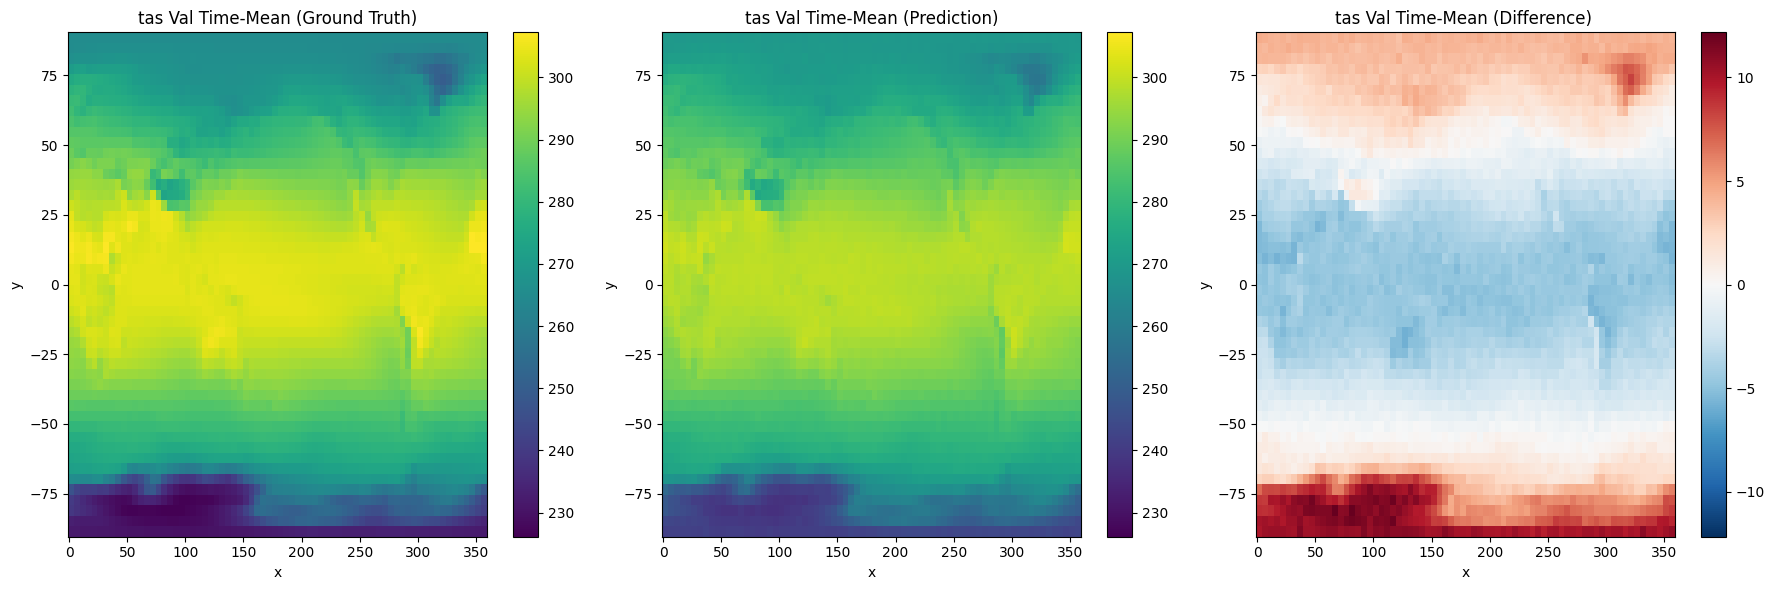

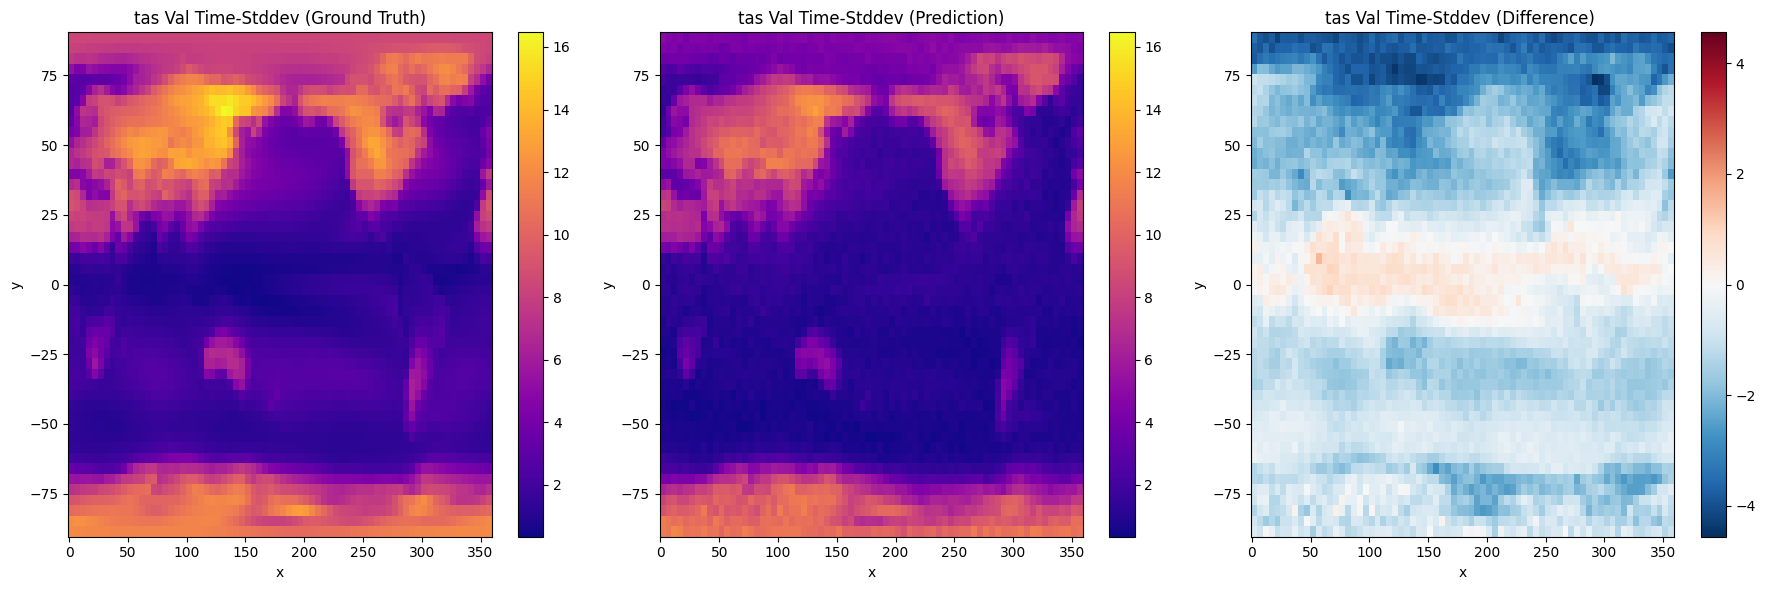

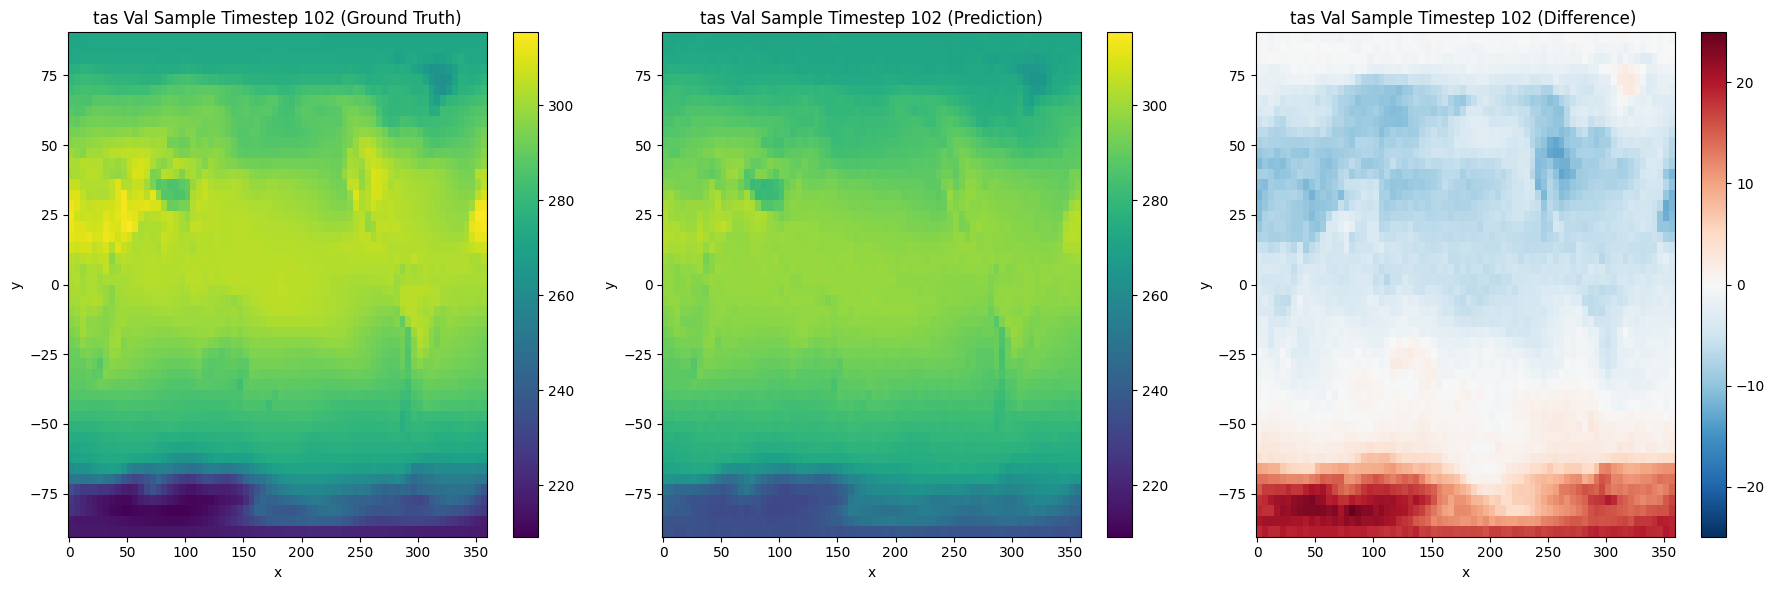

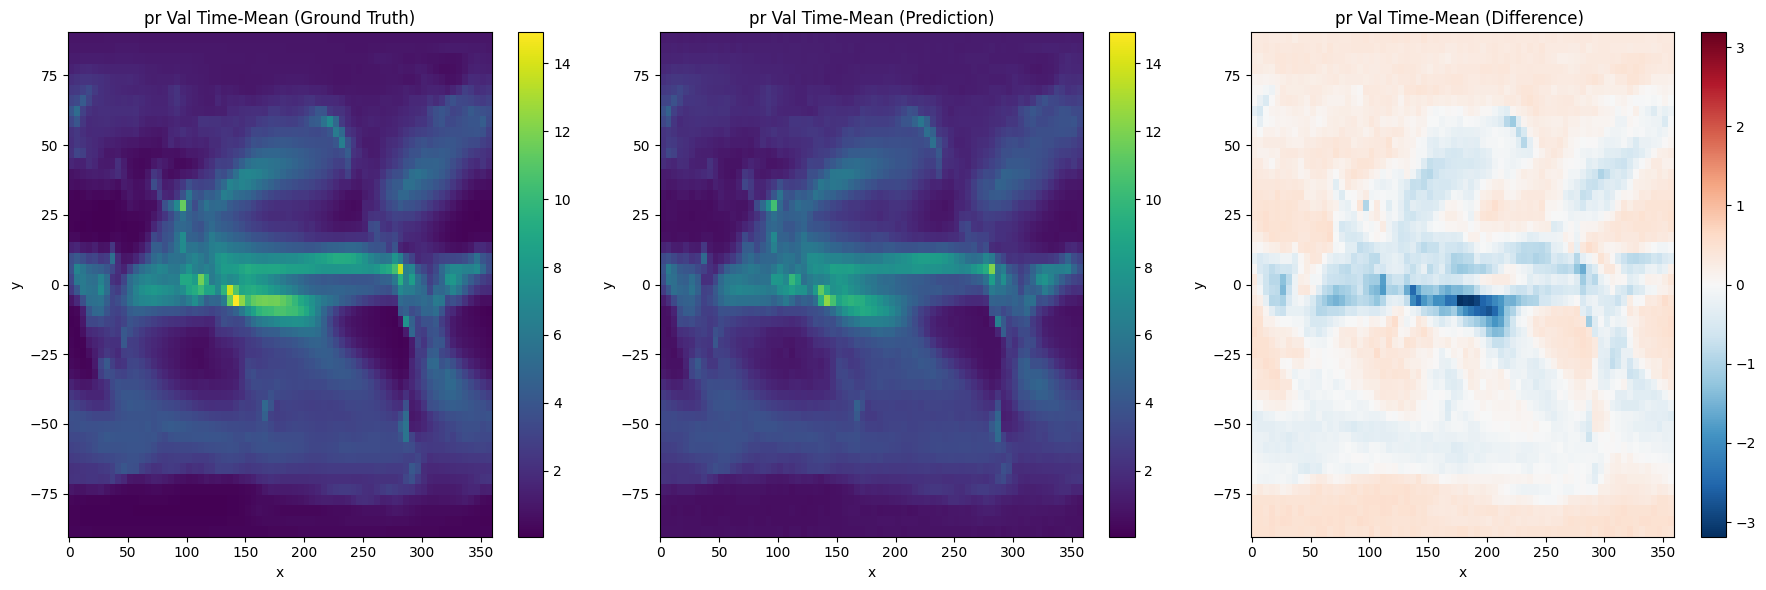

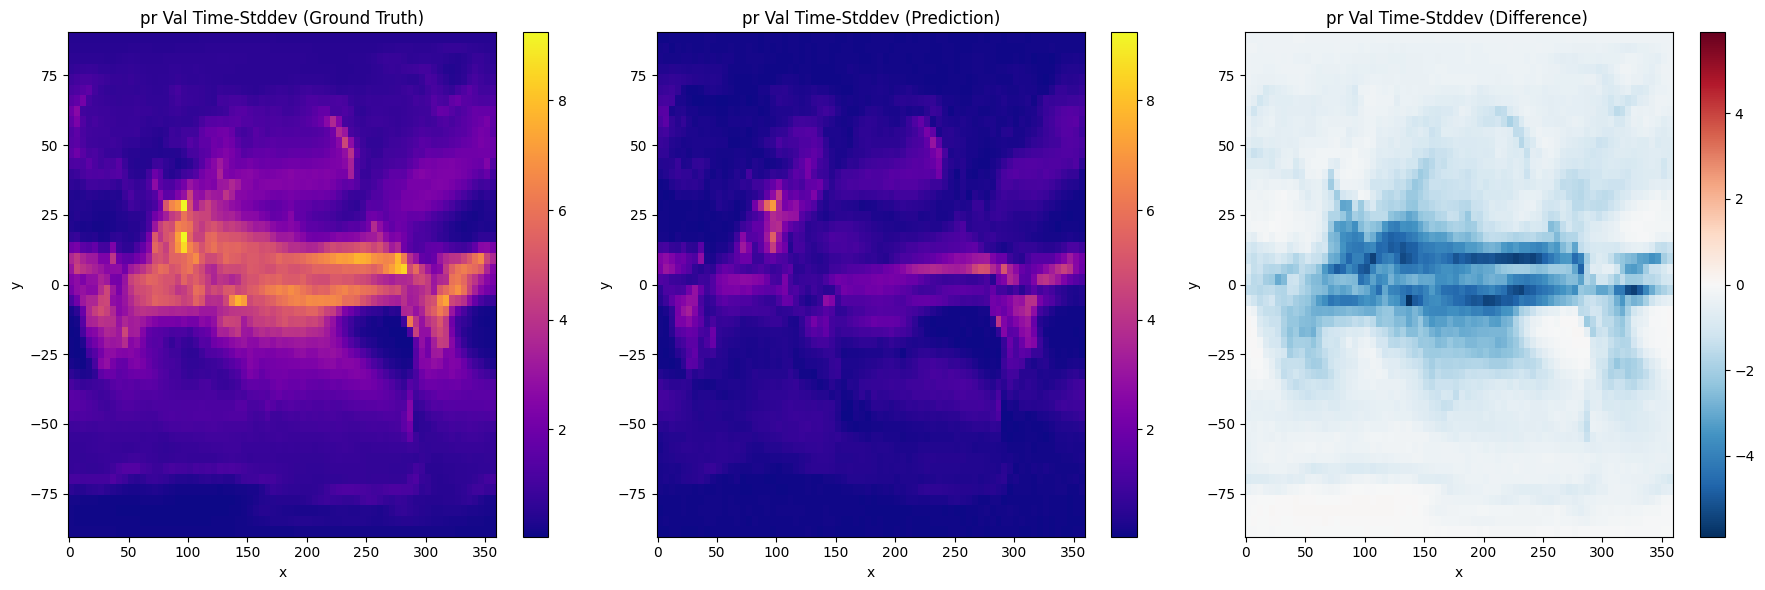

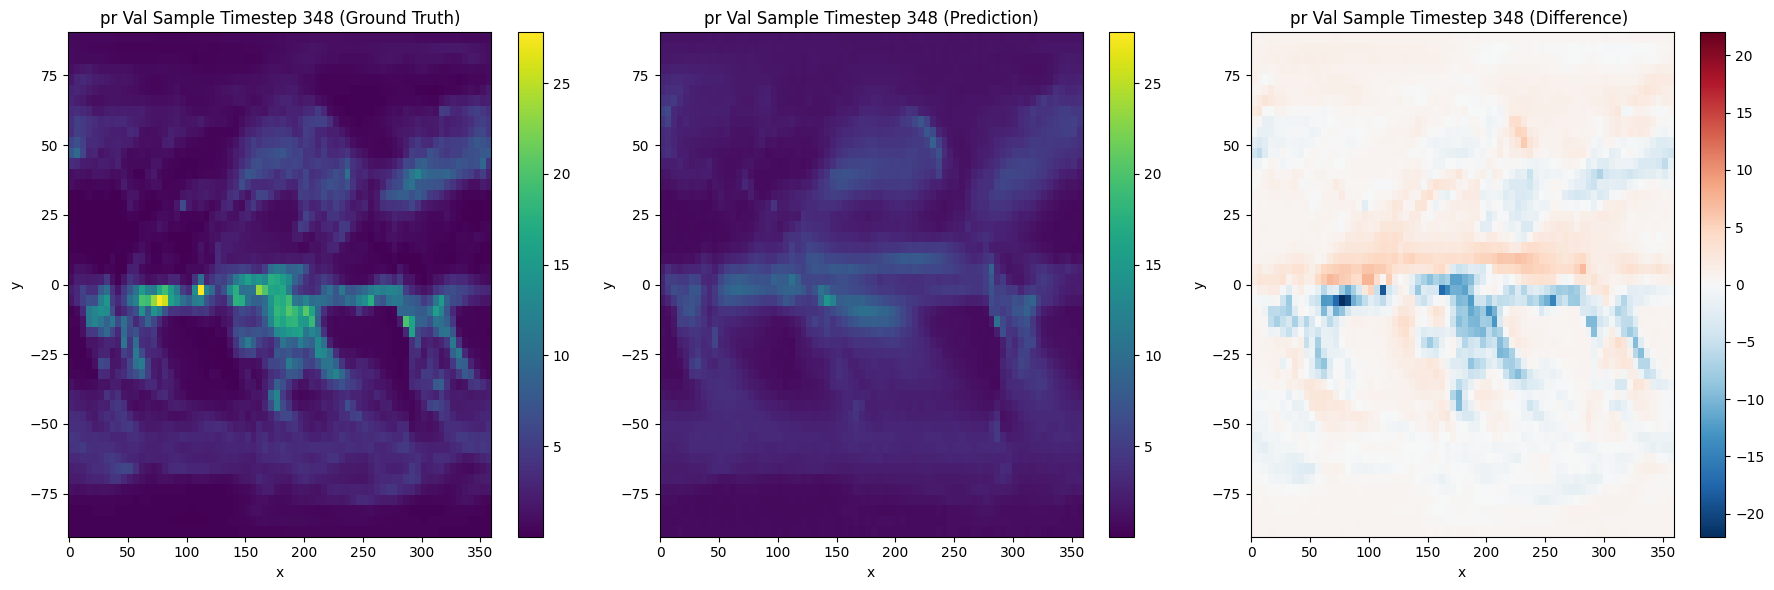

In [67]:
# Load validation predictions
# make sure to have run the validation loop at least once
val_preds = np.load("val_preds.npy")
val_trues = np.load("val_trues.npy")

lat, lon = datamodule.get_coords()
output_vars = datamodule.output_vars
time = np.arange(val_preds.shape[0])

for i, var in enumerate(output_vars):
    pred_xr = xr.DataArray(val_preds[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
    true_xr = xr.DataArray(val_trues[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

    # --- Time Mean ---
    plot_comparison(true_xr.mean("time"), pred_xr.mean("time"), f"{var} Val Time-Mean")

    # --- Time Stddev ---
    plot_comparison(true_xr.std("time"), pred_xr.std("time"), f"{var} Val Time-Stddev", cmap="plasma")

    # --- Random timestep ---
    t_idx = np.random.randint(0, len(time))
    plot_comparison(true_xr.isel(time=t_idx), pred_xr.isel(time=t_idx), f"{var} Val Sample Timestep {t_idx}")


## 🧪 Final Notes

This notebook is meant to serve as a **baseline template** — a starting point to help you get up and running quickly with the climate emulation challenge.

You are **not** required to stick to this exact setup. In fact, we **encourage** you to:

- 🔁 Build on top of the provided `DataModule`. 
- 🧠 Use your own model architectures or training pipelines that you’re more comfortable with 
- ⚗️ Experiment with ideas  
- 🥇 Compete creatively to climb the Kaggle leaderboard  
- 🙌 Most importantly: **have fun** and **learn as much as you can** along the way

This challenge simulates a real-world scientific problem, and there’s no single "correct" approach — so be curious, experiment boldly, and make it your own!
